In [1]:
import jax.numpy as jnp
import jax.random as jrd

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Model sepecification
Le modèle que l'on souhaite étudier est le suivant :

$$Y_{ij} | b_{i} \sim \mathcal N(\eta_{ij}, 1)$$

Où $\eta_{ij} =\sum_{k=1}^p x_{ij,k} \beta_{k} + b_i ~, b_i\sim\mathcal N(0, \sigma_b^2=0.1^2)$ et $b_i  \sim \mathcal N(\mu, \Gamma^2)$,  X= [Ut, U']

Le code ci-dessous le définie pour python.

In [2]:
def m(
    params, times: jnp.ndarray, b: jnp.ndarray, cov: jnp.ndarray, **kwargs
) -> jnp.ndarray:

    out = (cov @ params.beta).reshape(times.shape) + b[:, None]
    assert out.shape == times.shape
    return out

In [3]:
import functools
from jax import jit


from sdg4varselect.models import AbstractMEM, AbstractHDModel


class LogisticMixedEffectsModel(AbstractMEM, AbstractHDModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, P=1, **kwargs):
        AbstractHDModel.__init__(self, P=P)
        AbstractMEM.__init__(self, N=N, J=J, me_name=["b"], **kwargs)

    @property
    def name(self):
        """return a str called name, based on the parameter of the model"""
        return f"LMEM{self.N}_J{self.J}_P{self.P}"

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.Real(shape=(1,), scale=(1,)),
            cov_latent=pc.MatrixDiagPosDef(dim=1, scale=(1,)),
            var_residual=pc.RealPositive(scale=1),
            beta=pc.Real(scale=1, shape=(self.P,)),
        )
        self.parametrization_size = self._parametrization.size

    @property
    def name(self):
        return f"tutorial_logi_MEM_N{self.N}_J{self.J}_P{self.P}"

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):

        (
            prngkey_time,
            prngkey_mem,
            prngkey_cov,
        ) = jrd.split(prngkey, num=3)

        # === nlmem_simulation() === #
        time = jnp.linspace(0.01, 1, self.J)
        time = jnp.tile(time, (self.N, 1))

        cov = jrd.uniform(
            prngkey_cov, minval=-0.1, maxval=0.1, shape=(self.N * self.J, self.P)
        )
        cov = cov.at[:, 0].set(jnp.ones(shape=(cov.shape[0],)))
        cov *= jnp.concatenate(
            [
                jnp.repeat(
                    time.reshape((self.N * self.J,))[:, None], self.P // 2, axis=-1
                ),
                jnp.ones(shape=(self.N * self.J, self.P // 2)),
            ],
            axis=-1,
        )  # cov = [cov_1*time | cov_2]

        obs, sim = AbstractMEM.sample(
            self, params_star, prngkey_mem, mem_obs_time=time, cov=cov
        )

        return {"mem_obs_time": time, "cov": cov} | obs, sim

Text(0.5, 0, 'Observation times')

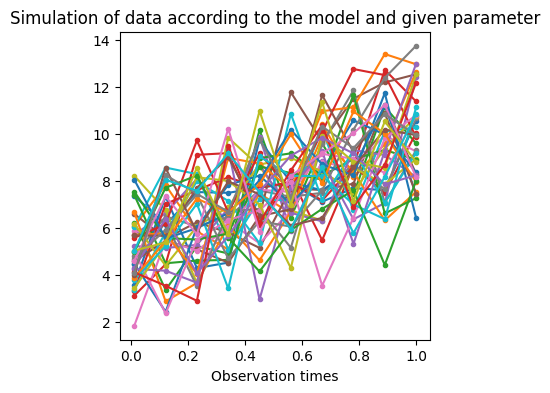

In [4]:
myModel = LogisticMixedEffectsModel(N=40, J=10, P=100)

p_star = myModel.new_params(
    mean_latent=jnp.array([5]),
    cov_latent=jnp.diag(jnp.array([0.1])),
    var_residual=1,
    beta=jnp.concatenate(
        [
            jnp.array([5, -15, 20]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
            jnp.array([-10, 15, 5]),
            jnp.zeros(shape=(myModel.P // 2 - 3,)),
        ]
    ),
)

myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))

ax = sdgplt.ax(4, 4)
_ = ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, ".-")
ax.set_title("Simulation of data according to the model and given parameter")
ax.set_xlabel("Observation times")

In [5]:
from sdg4varselect.outputs import MultiGDResults
from sdg4varselect.algo import SPGD_Prec
import sdg4varselect.algo.preconditioner as preconditioner

FIM = preconditioner.Fisher()
algo = SPGD_Prec(FIM, lbd=800, save_all=False)
algo.init_mcmc(myModel, adaptative_sd=False)  # , sd={"b": 5, "phi2": 20})

theta0 = 0.2 * jrd.normal(jrd.PRNGKey(0), shape=(myModel.parametrization.size,))


def one_estim(prngkey, model, data, lbd):
    prngkey_theta, prngkey = jrd.split(prngkey)
    theta0 = 0.2 * jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
    algo.set_seed(prngkey)
    algo.lbd = lbd
    res = algo.fit(model, data, theta0)
    return res


def one_estim_clever(prngkey, model, theta0, data, lbd):
    algo.set_seed(prngkey)
    algo.lbd = lbd
    res = algo.fit(model, data, theta0)
    return res


# res = one_estim_clever(jrd.PRNGKey(0), myModel, theta0, data=myobs, lbd=0.0001)

# multi_estim = MultiGDResults(
#     [one_estim(jrd.PRNGKey(i), myModel, myobs, lbd=0.0001) for i in range(1)]
# )
# multi_estim.last_theta

In [18]:
from sdg4varselect._regularization_function import (
    regularization_path,
    regularization_path_clever,
)

lbd_set = jnp.linspace(10**-1, 10**0, num=10)
multi_estim = regularization_path(
    one_estim,
    jrd.PRNGKey(0),
    lbd_set,
    model=myModel,
    data=myobs,
)

multi_estim_clever = regularization_path_clever(
    one_estim_clever,
    jrd.PRNGKey(0),
    lbd_set,
    theta0=0.2 * jrd.normal(jrd.PRNGKey(0), shape=(myModel.parametrization.size,)),
    model=myModel,
    data=myobs,
)

0
1
2
3
4
5
6
7
8
9


0:01:08.388746
0:01:10.510410


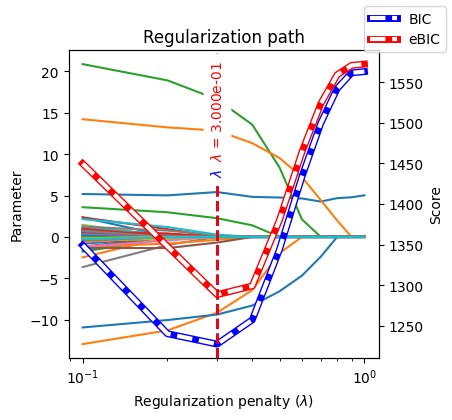

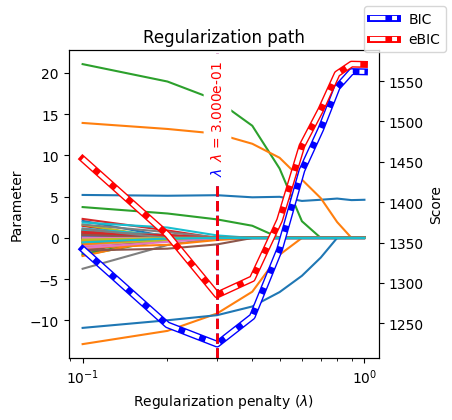

In [20]:
multi_estim.plot(sdgplt.figure(4,4), P = myModel.P)
print(multi_estim.chrono)
multi_estim_clever.plot(sdgplt.figure(4,4), P = myModel.P)
print(multi_estim_clever.chrono)

In [9]:
res = one_estim_clever(
    jrd.PRNGKey(0),
    myModel,
    theta0=multi_estim_clever[0].theta_reals1d[-1,],
    data=myobs,
    lbd=0.0001,
)

res.last_theta

Array([ 4.83018534e+00,  9.57343094e-02,  6.70678687e-01,  5.32730893e+00,
       -1.38343608e+01,  2.26497586e+01, -2.36730321e+00,  4.41689481e-01,
        2.04641788e+00,  6.42772402e-01,  7.72692689e-03, -4.15605907e-01,
       -8.51829738e-01, -9.41989894e-02, -2.02804661e+00, -2.70452586e+00,
        2.50759471e+00, -2.52241917e+00, -3.59280895e+00,  2.69374211e+00,
        4.00016166e-01,  3.63144824e+00,  1.91640014e+00, -1.46296081e+00,
        5.74952879e-01, -3.11321312e+00,  1.54160004e+00, -8.56431302e-01,
        2.72478918e+00, -8.20196467e-01,  1.33351972e+00, -3.17633477e+00,
       -1.75558714e+00,  3.40078831e+00, -3.36796879e-01, -1.32648626e-01,
        2.42606178e+00, -3.27235428e+00, -2.79496726e+00,  2.57594816e-01,
       -6.86363713e+00,  6.16926076e-01,  2.93835150e+00,  3.48054950e-01,
       -4.58859786e+00,  1.06755071e+00,  3.73632016e+00,  2.06091235e+00,
        6.00380863e-01, -1.15397085e+00,  1.01576333e+00,  3.06439113e+00,
        2.45262457e+00, -

In [10]:
multi_estim_clever.last_theta[jnp.argmin(multi_estim_clever.ebic),]

Array([ 4.87530583e+00,  5.32648228e-05,  1.04677696e+00,  5.18421995e+00,
       -9.15664241e+00,  1.66811293e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [11]:
multi_estim_clever[3].latent_variables

{'b': array([5.03308881, 5.03123447, 5.03032153, 5.0303438 , 5.03156891,
        5.03151407, 5.03189024, 5.02973063, 5.03036991, 5.02822618,
        5.03022895, 5.03146627, 5.03210132, 5.03319221, 5.02891187,
        5.02959219, 5.03105369, 5.02902775, 5.0321153 , 5.02883052,
        5.03100178, 5.02962437, 5.03158452, 5.03080611, 5.03214178,
        5.03066805, 5.03317519, 5.03105799, 5.03146499, 5.03081186,
        5.0315023 , 5.0322622 , 5.03058336, 5.03082879, 5.03052403,
        5.03068999, 5.02994866, 5.03060279, 5.03266972, 5.03040322])}

In [12]:
multi_estim_clever[2].theta_reals1d[:3, :5]

Array([[  4.90662928, -10.00665574,   0.49078662,   5.11739862,
        -11.26757546],
       [  4.87530583,  -9.8402078 ,   0.61435049,   5.18421995,
         -9.15664241]], dtype=float64)

In [13]:
t = multi_estim_clever[2].theta_reals1d[0,]
print(t[:5])
dt = algo.get_log_likelihood_kwargs(myobs)
print(dt["b"])
jac = myModel.jac_log_likelihood(t, **dt)
print(jac.mean(axis=0)[:5])
algo._preconditioner.get_preconditioned_gradient(jac.mean(axis=0), jac, 1)[1][:5]

[  4.90662928 -10.00665574   0.49078662   5.11739862 -11.26757546]
[5.14396456 5.3015956  4.63023759 4.73940619 4.49896823 4.91931711
 4.66615547 4.5453507  5.09056882 4.74437275 4.44932815 4.71107944
 4.44607376 4.88243483 4.94085553 5.26827242 4.94187893 4.82670286
 4.92499754 4.76035638 4.57932267 5.51548635 4.72804541 4.99601047
 4.37925514 5.00716432 4.6947237  5.33843934 5.00471813 4.90896157
 5.13590883 4.5230294  4.77734693 4.351199   4.54656638 4.5963846
 4.66142915 5.28137982 5.03927636 5.00959764]
[-1.52946076e+03  9.36181323e+02  1.12153096e-02  3.97882094e-01
 -3.38672691e-02]


Array([-1.52946078e+03,  9.36181331e+02,  1.12153097e-02,  3.97882097e-01,
       -3.38672694e-02], dtype=float64)

In [14]:
multi_estim_clever[2].grad[:3, :5]

Array([[ 1.47895395e-07, -1.97687147e-10,  2.08257832e-09,
         3.46955700e-10, -3.15913856e-10],
       [ 1.10765167e-06, -2.43780692e-04,  5.21230224e-05,
        -5.30283353e-05, -2.62289453e-03]], dtype=float64)

In [15]:
t = multi_estim_clever[1].theta_reals1d[-1]
myModel.parametrization.reals1d_to_params(t)

Parameters(mean_latent=Array([4.90662914], dtype=float64), cov_latent=Array([[4.50977459e-05]], dtype=float64), var_residual=Array(0.96835201, dtype=float64), beta=Array([ 5.11739862e+00, -1.12675755e+01,  1.89681170e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.98784848e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.55516016e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.70905076e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.74194043e-04,
        0.00000000e+00, -8.55542143e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.09098541e-01,
        0.0

In [16]:
jnp.argmin(multi_estim.ebic)

NameError: name 'multi_estim' is not defined

In [ ]:
myModel.hstack_params(p_star)

In [ ]:
multi_estim[jnp.argmin(multi_estim.ebic)].last_theta

In [ ]:
p_names = ["$intercept$", "$sd(b)$", "$\\sigma^2$"] + [
    f"$\\beta_{{{i}}}$" for i in range(myModel.P)
]

r = multi_estim_clever  # [2]

fig = sdgplt.figure(8, 8)
_ = sdgplt.plot_theta(
    r,
    fig=fig.subfigures(1, 2, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[
        [0, 1, 2],
        [
            3,
            4,
            5,
            6,
            myModel.P // 2 + 3,
            myModel.P // 2 + 4,
            myModel.P // 2 + 5,
            myModel.P // 2 + 6,
        ],
    ],
)

fig = sdgplt.figure(8 * 4, 8 * 4)
_ = sdgplt.plot_theta(
    r,
    fig=fig.subfigures(1, 10, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[[i + 10 * j + 3 for i in range(myModel.P // 10)] for j in range(10)],
)